In [1]:
# Uncomment to install needed pip package in the current Jupyter kernel the right way
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/#How-to-use-Pip-from-the-Jupyter-Notebook
#import sys
#!{sys.executable} -m pip install flipper-raw-rfid matplotlib ipympl



In [2]:
# Use local flipper_raw_rfid if available
from pathlib import Path
import sys 

module_path = Path('.').absolute().parent
if module_path not in sys.path:
    sys.path.append(module_path)


(0.0, 20000.0)

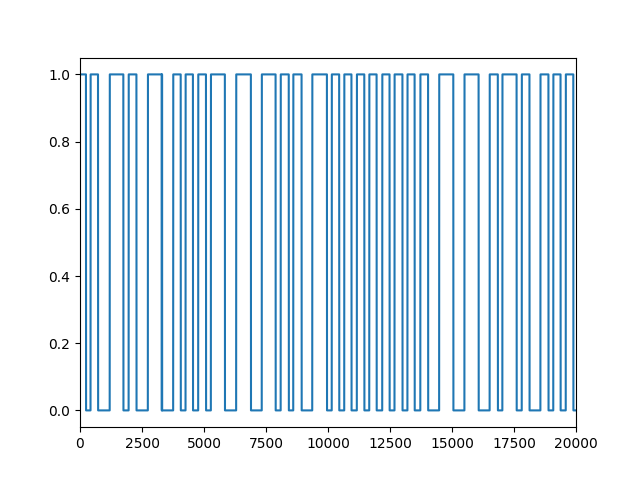

In [3]:
%matplotlib widget

from flipper_raw_rfid.rifl import Rifl
from flipper_raw_rfid.utils import batched, pad_to_signal, signal_to_pad, autocorrelate, smooth, binarize, find_first_transition_index, find_peaks, histogram, smooth, binarize
from flipper_raw_rfid.bits import decode_lengths, decode_manchester, decode_em_4100, to_str
from matplotlib import pyplot as plt
from scipy import signal as scipy_signal
import numpy as np
import numpy 
import sys


# Basic usage

rifl = Rifl.load('../tests/assets/Red354.ask.raw')
#rifl = RiflFile.load('examples/indala.psk.raw')

# Get the signal as pulse length and duration length measured in µs
pad = rifl.pulse_and_durations
# Convert it into something more usable (vector of 0 and 1) 
signal = pad_to_signal(pad)

fig, ax = plt.subplots()
ax.plot(signal)
ax.set_xlim(0,20000)

# Yeah looks like a signal

[Peak(left=276, center=32708, right=32984),
 Peak(left=32984, center=65416, right=65693),
 Peak(left=65693, center=98124, right=98401),
 Peak(left=98401, center=130832, right=131109),
 Peak(left=131109, center=163540, right=163817)]

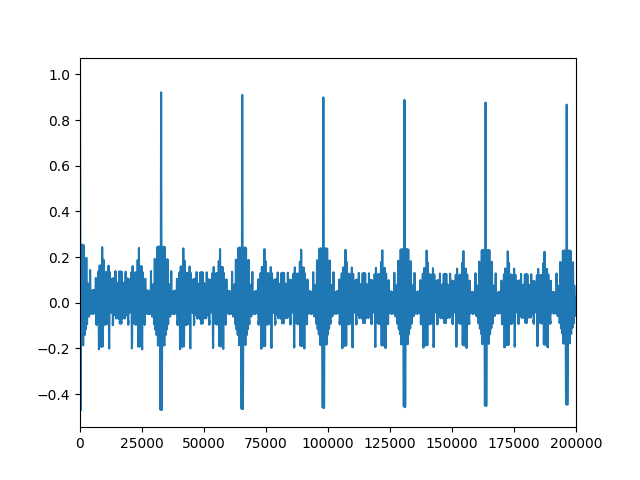

In [4]:
# If it is a real signal there should be some repetition in it
# it gets send several times, so we assume it will have a correlation with itself
signal_autocorrelation = autocorrelate(signal)
fig, ax = plt.subplots()
ax.plot(signal_autocorrelation)
ax.set_xlim(0,200000)

peaks = find_peaks(signal_autocorrelation, min_height=0.75)

display(peaks[:5])
# There are peaks at 32708 and more or less multiples of it, looks good

Text(0.5, 1.0, 'Binarized again')

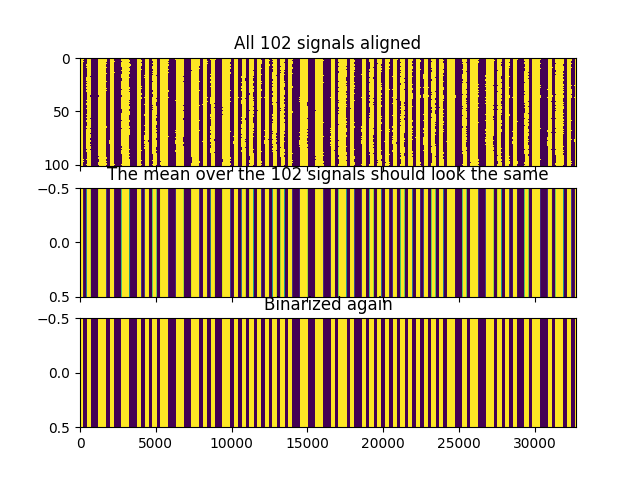

In [5]:
# The first peak (32708) looks good, take it
signal_length = peaks[0].center
# number of whole repetitions of the signal
number_signals = int(len(signal)/signal_length)
# wrap signal every signal_length samples
vis = signal[:number_signals*signal_length].reshape((number_signals, signal_length))

fig, ax = plt.subplots(3,1, sharex=True)
ax[0].imshow(vis, aspect='auto', interpolation='none')
ax[0].set_title(f'All {number_signals} signals aligned')

mean_signal = vis.mean(axis=0)
ax[1].imshow(mean_signal.reshape((1,-1)), aspect='auto', interpolation='none')
ax[1].set_title(f'The mean over the {number_signals} signals should look the same')

binarized_mean_signal = binarize(mean_signal)
ax[2].imshow(binarized_mean_signal.reshape((1,-1)), aspect='auto', interpolation='none')
ax[2].set_title(f'Binarized again')

                    

[Peak(left=225, center=255, right=285), Peak(left=485, center=510, right=536)]

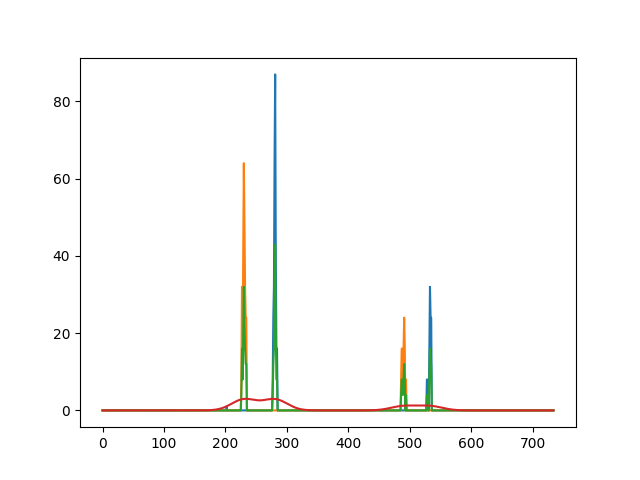

In [6]:
pad = signal_to_pad(np.tile(binarized_mean_signal,8))

# How long is the signal 1
one_times = pad[:,0]
# How long is the signal 0
zero_times = pad[:,1] - pad[:,0]

# Build a histogram with both 
combined_length = np.max([one_times,zero_times])+200
one_times_hist = histogram(one_times,min_length=combined_length)
zero_times_hist = histogram(zero_times,min_length=combined_length)
hist = (one_times_hist+zero_times_hist)//2

fig, ax = plt.subplots(sharex=True)

#ax.plot(hist)
ax.plot(one_times_hist) # blue 
ax.plot(zero_times_hist) # orange
ax.plot(hist) # green

# smoothing the combined histogram to blur the peaks together
sm = smooth(hist, sigma=20)
ax.plot(sm)

# Search for peaks
pks = find_peaks(sm)
# And trim them to the original unsmoothed histogram
pks = [p.fit(hist) for p in pks]

# We should have two peaks for manchester encoded signal (short/long) the 2nd center should be around twice as big as the 1st
display(pks)
# For raw encodings there can be several peaks, each center should be a multiple of the first


Found nothing for high 202, restarting
1001101001100101010110011001101010011010101010101010100110011001011010010101010101010101010101100101100110101010010110010110101010011010011001010101100110011010100110101010101010101001100110010110100101010101010101010101011001011001101010100101100101101010100110100110010101011001100110101001101010101010101010011001100101101001010101010101010101010110010110011010101001011001011010101001101001100101010110011001101010011010101010101010100110011001011010010101010101010101010101100101100110101010010110010110101010011010011001010101100110011010100110101010101010101001100110010110100101010101010101010101011001011001101010100101100101101010100110100110010101011001100110101001101010101010101010011001100101101001010101010101010101010110010110011010101001011001011010101001101001100101010110011001101010011010101010101010100110011001011010010101010101010101010101100101100110101010010110010110101010011010011001010101100110011010100110101010101010101001100110010

(0.0, 256.0)

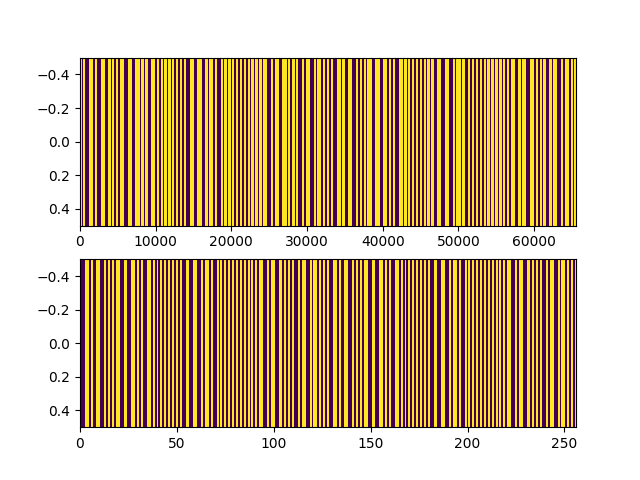

In [7]:
bits, start = decode_lengths(pad, pks)

print(to_str(bits), start)

fx, ax = plt.subplots(2)

frq = 256 # pks[0].center
sx,ex = 0, 256


ax[0].imshow(signal[start:].reshape((1,-1)), aspect='auto', interpolation='none')
ax[0].set_xlim(sx*frq,ex*frq)

ax[1].imshow(bits.reshape((1,-1)), aspect='auto', interpolation='none')
ax[1].set_xlim(sx,ex)



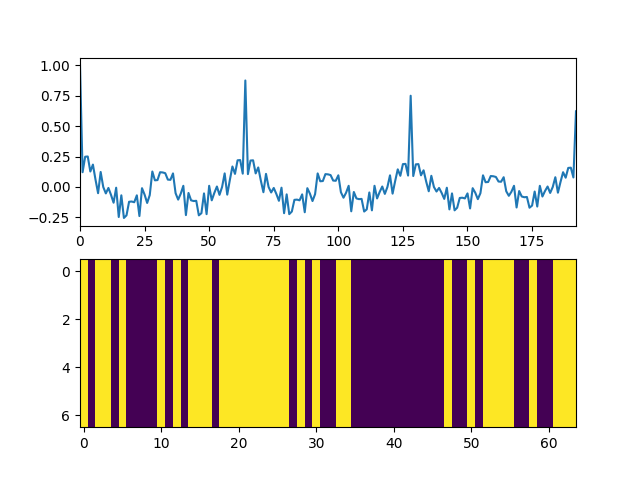

In [8]:
# ASK is manchester encoded
decoded_bits = decode_manchester(bits)

fix, ax = plt.subplots(2)


acb = autocorrelate(decoded_bits)
peaks = find_peaks(acb, min_height=0.5)
# There are repetitions every 64 bits
bit_signal_length = peaks[0].center

ax[0].plot(acb)
ax[0].set_xlim(0,peaks[-1].center)



# For the visualizetion we put each signal below each other
number_bit_signals = int(len(decoded_bits)/bit_signal_length)
vis = decoded_bits[:number_bit_signals*bit_signal_length].reshape((number_bit_signals, bit_signal_length))

ax[1].imshow(vis, aspect='auto', interpolation='none')




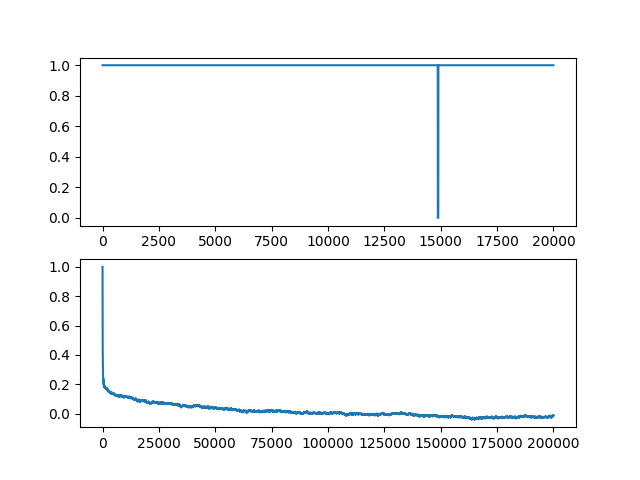

In [9]:
# Lets compare it to when there is no data in the file
rifl = Rifl.load('../tests/assets/Nothing.ask.raw')

no_signal = pad_to_signal(rifl.pulse_and_durations)

fix, ax = plt.subplots(2)

# Looks strange
ax[0].plot(no_signal[:20000])

no_signal_autocorrelation = autocorrelate(no_signal)

# And has no visible autocorrelation
ax[1].plot(no_signal_autocorrelation[:200000])


In [10]:
# To be continued